###بِسْمِ ٱللَّٰهِ ٱلرَّحْمَٰنِ ٱلرَّحِيمِ

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!pip install ipython-autotime
%load_ext autotime

time: 117 µs (started: 2021-01-07 20:40:18 +00:00)


## Load VGG16 model

In [5]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten

time: 1.38 s (started: 2021-01-07 20:40:18 +00:00)


In [6]:
width = 75
height =75
epochs_count = 10
batch_length = 64

time: 1.91 ms (started: 2021-01-07 20:40:19 +00:00)


In [7]:
# load VGG16 model without classification layers
vgg_16_model = VGG16(include_top=False, input_shape=(width, height, 3))

58892288/58889256 [==============================] - 0s 0us/step
time: 6.14 s (started: 2021-01-07 20:40:19 +00:00)


In [8]:
# add new classification layers
flat1 = Flatten()(vgg_16_model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer

time: 19.7 ms (started: 2021-01-07 20:40:26 +00:00)


In [9]:
# define the new model
vgg_16_model = Model(inputs=vgg_16_model.inputs, outputs=output)
vgg_16_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75, 75, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0     

### Load Data Libraries

In [10]:
# necessary imports
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm
import matplotlib.pyplot as plt

time: 1.15 s (started: 2021-01-07 20:40:26 +00:00)


### Loading Data Function 

In [11]:
# A function to load data from a given directory
def load_data(data_dir):
  names = {} #added -labels and there count
  data = []
  labels = []
  class_dirs = os.listdir(data_dir)
  
  for direc in class_dirs:
    class_dir = os.path.join(data_dir, direc)
    names[class_dir.split('/')[-1]] = len(list(paths.list_images(class_dir))) #added
    for imagepath in tqdm(list(paths.list_images(class_dir))):
      image = cv2.imread(imagepath)
      image = cv2.resize(image, (width, height))  # incase images not of same size
      data.append(image)
      labels.append(direc)
  # normalizing and converting to numpy array format
  data = np.array(data, dtype='float')/255.0
  labels = np.array(labels)
  return data, labels, names #added names

time: 7.87 ms (started: 2021-01-07 20:40:27 +00:00)


## Paths

In [12]:
train_dir = "/content/drive/MyDrive/Colab Notebooks/Natural Scenes/seg_training/"
test_dir = "/content/drive/MyDrive/Colab Notebooks/Natural Scenes/seg_testing/"
pred_dir = "/content/drive/MyDrive/Colab Notebooks/Natural Scenes/seg_validation/"

time: 1.16 ms (started: 2021-01-07 20:40:27 +00:00)


Loading Data

In [13]:
print('Loading Train Images')
X_train, Y_train, labels_count_train = load_data(train_dir)

print('Loading Validate Images')
X_valid, Y_valid, labels_count_valid = load_data(test_dir)

Loading Train Images


100%|██████████| 2274/2274 [09:28<00:00,  4.00it/s]


Loading Validate Images


100%|██████████| 525/525 [02:29<00:00,  3.52it/s]


time: 1h 16min 48s (started: 2021-01-07 20:40:27 +00:00)


In [14]:
print(labels_count_train)
print('Total Train Data:',sum(labels_count_train.values()))

{'forest': 2271, 'buildings': 2191, 'glacier': 2404, 'mountain': 2512, 'street': 2382, 'sea': 2274}
Total Train Data: 14034
time: 2.42 ms (started: 2021-01-07 21:57:16 +00:00)


In [15]:
print(labels_count_valid)
print('Total Test Data:',sum(labels_count_valid.values()))

{'buildings': 437, 'street': 501, 'forest': 474, 'glacier': 553, 'sea': 510, 'mountain': 525}
Total Test Data: 3000
time: 1.93 ms (started: 2021-01-07 21:57:16 +00:00)


In [16]:
lb = LabelBinarizer()
Y_train = lb.fit_transform(Y_train)
Y_valid = lb.fit_transform(Y_valid)

time: 24.2 ms (started: 2021-01-07 21:57:16 +00:00)


Visualize Data Function

In [17]:
def visualize_data(images, categories, class_names):
    fig = plt.figure(figsize=(14, 6))
    fig.patch.set_facecolor('#ffffd9')
    for i in range(3 * 6):
        plt.subplot(3, 6, i+1)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(images[i])
        class_index = categories[i].argmax()
        plt.xlabel(class_names[class_index])
    plt.show()

time: 5.34 ms (started: 2021-01-07 21:57:16 +00:00)


In [18]:
class_names = list(labels_count_train.keys())
class_names

['forest', 'buildings', 'glacier', 'mountain', 'street', 'sea']

time: 4.31 ms (started: 2021-01-07 21:57:16 +00:00)


### Compile the model

optimizer

In [19]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

time: 2.04 ms (started: 2021-01-07 21:57:16 +00:00)


In [20]:
class LearningRateReducerCb(tf.keras.callbacks.Callback):

  def on_epoch_end(self, epoch, logs={}):
    old_lr = self.model.optimizer.lr.read_value()
    new_lr = old_lr * 0.99
    print("\nEpoch: {}. Reducing Learning Rate from {} to {}".format(epoch, old_lr, new_lr))
    self.model.optimizer.lr.assign(new_lr)

time: 3.49 ms (started: 2021-01-07 21:57:16 +00:00)


In [21]:
# from keras.optimizers import SGD
# sgd = SGD(lr=0.001, decay=1e-7, momentum=.9)

time: 730 µs (started: 2021-01-07 21:57:16 +00:00)


In [22]:
from keras.optimizers import Adam
aadam = Adam(learning_rate=0.0001)

time: 1.37 ms (started: 2021-01-07 21:57:16 +00:00)


In [23]:
vgg_16_model.compile(loss='categorical_crossentropy', 
              optimizer=aadam,
              metrics=['accuracy'])

time: 25.6 ms (started: 2021-01-07 21:57:16 +00:00)


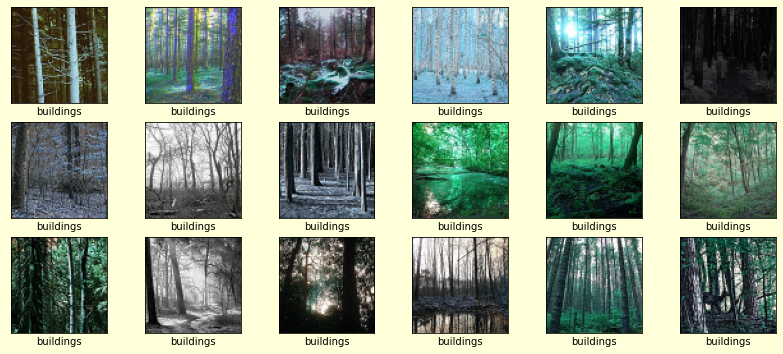

time: 590 ms (started: 2021-01-07 21:57:16 +00:00)


In [24]:
visualize_data(X_train, Y_train, class_names)

# Train The Model With Out Augmentation

In [25]:
With_Out_Aug_16 = vgg_16_model.fit(X_train, Y_train,
                        #  callbacks=[LearningRateReducerCb()],
              batch_size= batch_length,
              epochs=epochs_count,
              validation_data=(X_valid, Y_valid))

Epoch 1/10
220/220 [==============================] - 37s 128ms/step - loss: 0.6712 - accuracy: 0.7407 - val_loss: 0.2975 - val_accuracy: 0.8950
Epoch 2/10
220/220 [==============================] - 27s 124ms/step - loss: 0.2657 - accuracy: 0.9057 - val_loss: 0.3048 - val_accuracy: 0.8890
Epoch 3/10
220/220 [==============================] - 28s 126ms/step - loss: 0.2018 - accuracy: 0.9280 - val_loss: 0.3326 - val_accuracy: 0.8837
Epoch 4/10
220/220 [==============================] - 28s 128ms/step - loss: 0.1674 - accuracy: 0.9403 - val_loss: 0.4073 - val_accuracy: 0.8807
Epoch 5/10
220/220 [==============================] - 28s 129ms/step - loss: 0.1569 - accuracy: 0.9465 - val_loss: 0.2810 - val_accuracy: 0.9053
Epoch 6/10
220/220 [==============================] - 28s 128ms/step - loss: 0.1087 - accuracy: 0.9659 - val_loss: 0.3085 - val_accuracy: 0.9003
Epoch 7/10
220/220 [==============================] - 28s 128ms/step - loss: 0.0635 - accuracy: 0.9787 - val_loss: 0.2875 - val_ac

In [26]:
print('Loading Test Images')
X_test, Y_test, labels_count_test = load_data(pred_dir)
Y_test = lb.fit_transform(Y_test)

Loading Test Images


100%|██████████| 1166/1166 [05:19<00:00,  3.64it/s]


time: 30min 52s (started: 2021-01-07 22:02:07 +00:00)


In [27]:
print(labels_count_test)
print('Total Test Data:',sum(labels_count_test.values()))

{'street': 1236, 'sea': 1128, 'mountain': 1297, 'glacier': 1330, 'buildings': 1144, 'forest': 1166}
Total Test Data: 7301
time: 2.17 ms (started: 2021-01-07 22:32:59 +00:00)


Learning Curves

In [28]:
# save the model's trained weights
vgg_16_model.save_weights('/content/drive/MyDrive/Colab Notebooks/Weights/vgg_transfer_trained_wts_with-out-aug2.h5')

time: 2.02 s (started: 2021-01-07 22:32:59 +00:00)


In [29]:
score_WOA_16 = vgg_16_model.evaluate(X_test, Y_test, batch_size=batch_length)
print('Test Loss = ', score_WOA_16[0])
print('Test Accuracy = ', score_WOA_16[1])

115/115 [==============================] - 4s 38ms/step - loss: 0.5171 - accuracy: 0.8803
Test Loss =  0.5171270370483398
Test Accuracy =  0.8802903890609741
time: 4.9 s (started: 2021-01-07 22:33:01 +00:00)


In [30]:
'''CONFUSION MATRIX'''
# Making prediction
y_pred = vgg_16_model.predict(X_test)
y_true = np.argmax(Y_test, axis=-1)

# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx_WOA_16 = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

time: 5.55 s (started: 2021-01-07 22:33:06 +00:00)


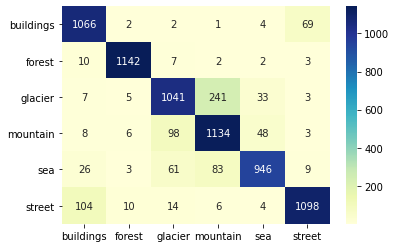

time: 372 ms (started: 2021-01-07 22:33:11 +00:00)


In [31]:
# confusion_mtx_WOA_16
import seaborn as sns

class_names = sorted(class_names)
sns.heatmap(confusion_mtx_WOA_16, xticklabels=class_names, yticklabels=class_names,
            annot=True, fmt='d', cmap="YlGnBu")

([<matplotlib.axis.XTick at 0x7f03623be908>,
 [Text(0, 0, 'buildings'),
  Text(0, 0, 'forest'),
  Text(0, 0, 'glacier'),
  Text(0, 0, 'mountain'),
  Text(0, 0, 'sea'),
  Text(0, 0, 'street')])

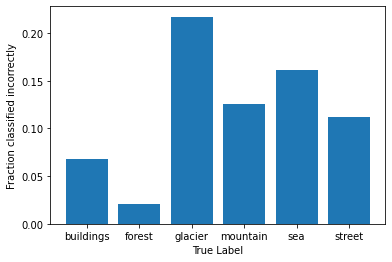

time: 139 ms (started: 2021-01-07 22:33:12 +00:00)


In [32]:
label_frac_error = 1 - np.diag(confusion_mtx_WOA_16) / np.sum(confusion_mtx_WOA_16, axis=1)
plt.bar(np.arange(6),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')
plt.xticks([0,1,2,3,4,5],class_names)

# Train The Model With Augmentation

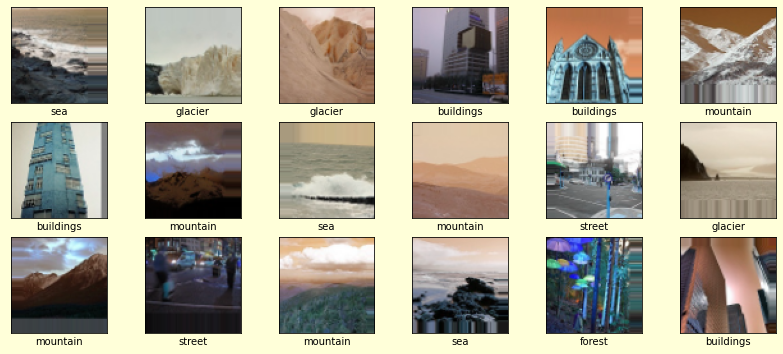

time: 947 ms (started: 2021-01-07 22:33:12 +00:00)


In [33]:
datagen = ImageDataGenerator(
    # rescale=1./255,
    # rotation_range=40,
    horizontal_flip=True,
    width_shift_range=15/75, #.2
    height_shift_range=15/75, #.2
    fill_mode='nearest',
    shear_range=0.2,
    zoom_range=0.1,
    )

Data_Augmentation = datagen.flow(X_train, Y_train, batch_size=batch_length, shuffle=True)
batch_images, batch_labels = next(Data_Augmentation)
visualize_data(batch_images, batch_labels, class_names)

In [34]:
With_Aug = vgg_16_model.fit(Data_Augmentation,
              batch_size=batch_length,
              epochs=epochs_count, 
              validation_data=(X_valid, Y_valid))

Epoch 1/10
220/220 [==============================] - 31s 138ms/step - loss: 0.2642 - accuracy: 0.9070 - val_loss: 0.3144 - val_accuracy: 0.8923
Epoch 2/10
220/220 [==============================] - 30s 138ms/step - loss: 0.2048 - accuracy: 0.9290 - val_loss: 0.2567 - val_accuracy: 0.9130
Epoch 3/10
220/220 [==============================] - 31s 139ms/step - loss: 0.1761 - accuracy: 0.9386 - val_loss: 0.2613 - val_accuracy: 0.9120
Epoch 4/10
220/220 [==============================] - 31s 140ms/step - loss: 0.1577 - accuracy: 0.9428 - val_loss: 0.2754 - val_accuracy: 0.9043
Epoch 5/10
220/220 [==============================] - 31s 139ms/step - loss: 0.1473 - accuracy: 0.9494 - val_loss: 0.3047 - val_accuracy: 0.8983
Epoch 6/10
220/220 [==============================] - 31s 139ms/step - loss: 0.1361 - accuracy: 0.9498 - val_loss: 0.4224 - val_accuracy: 0.8867
Epoch 7/10
220/220 [==============================] - 31s 139ms/step - loss: 0.1339 - accuracy: 0.9513 - val_loss: 0.5137 - val_ac

In [35]:
# save the model's trained weights
vgg_16_model.save_weights('/content/drive/MyDrive/Colab Notebooks/Weights/vgg_transfer_trained_wts_with-aug2.h5')

time: 1.46 s (started: 2021-01-07 22:38:19 +00:00)


In [36]:
score_WA_16 = vgg_16_model.evaluate(X_test, Y_test, batch_size=batch_length)
print('Test Loss = ', score_WA_16[0])
print('Test Accuracy = ', score_WA_16[1])

115/115 [==============================] - 4s 37ms/step - loss: 0.4915 - accuracy: 0.8800
Test Loss =  0.49152952432632446
Test Accuracy =  0.8800164461135864
time: 4.44 s (started: 2021-01-07 22:38:21 +00:00)


In [37]:
'''CONFUSION MATRIX'''
# Making prediction
y_pred = vgg_16_model.predict(X_test)
y_true = np.argmax(Y_test, axis=-1)

# Plotting the confusion matrix

confusion_mtx_WA_16 = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

time: 5.43 s (started: 2021-01-07 22:38:25 +00:00)


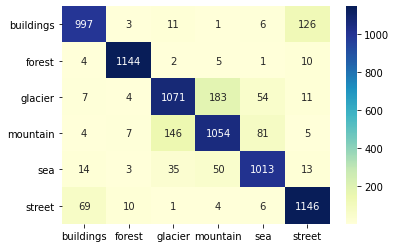

time: 308 ms (started: 2021-01-07 22:38:31 +00:00)


In [38]:
# confusion_mtx_WA_16
sns.heatmap(confusion_mtx_WA_16, xticklabels=class_names, yticklabels=class_names,
            annot=True, fmt='d', cmap="YlGnBu")

([<matplotlib.axis.XTick at 0x7f03622c9a58>,
 [Text(0, 0, 'buildings'),
  Text(0, 0, 'forest'),
  Text(0, 0, 'glacier'),
  Text(0, 0, 'mountain'),
  Text(0, 0, 'sea'),
  Text(0, 0, 'street')])

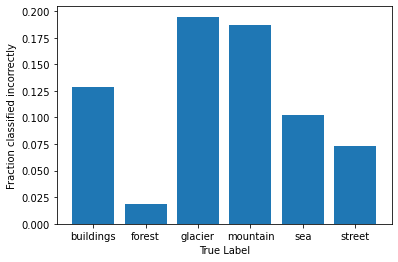

time: 168 ms (started: 2021-01-07 22:38:31 +00:00)


In [39]:
label_frac_error = 1 - np.diag(confusion_mtx_WA_16) / np.sum(confusion_mtx_WA_16, axis=1)
plt.bar(np.arange(6),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')
plt.xticks([0,1,2,3,4,5],class_names)

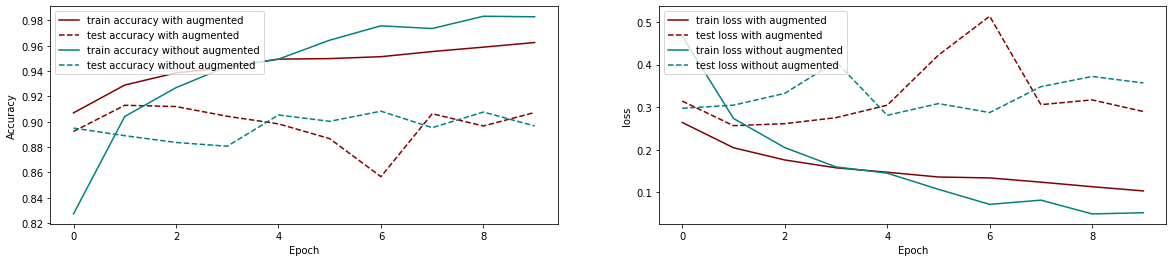

time: 1.52 s (started: 2021-01-07 22:38:31 +00:00)


In [40]:
# fig = plt.figure()
# fig.patch.set_facecolor('white')
fig, axis = plt.subplots(1, 2, figsize=(20, 4))
axis[0].plot(With_Aug.history['accuracy'],
         label='train accuracy with augmented',
         c='maroon', ls='-')
axis[0].plot(With_Aug.history['val_accuracy'],
         label='test accuracy with augmented',
         c='maroon',ls='--')

axis[0].plot(With_Out_Aug_16.history['accuracy'],
         label='train accuracy without augmented',
         c='teal', ls='-')
axis[0].plot(With_Out_Aug_16.history['val_accuracy'],
         label='test accuracy without augmented',
         c='teal', ls='--')

axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Accuracy')
axis[0].legend(loc='upper left')


axis[1].plot(With_Aug.history['loss'],
         label='train loss with augmented',
         c='maroon', ls='-')
axis[1].plot(With_Aug.history['val_loss'],
         label='test loss with augmented',
         c='maroon',ls='--')

axis[1].plot(With_Out_Aug_16.history['loss'],
         label='train loss without augmented',
         c='teal', ls='-')
axis[1].plot(With_Out_Aug_16.history['val_loss'],
         label='test loss without augmented',
         c='teal', ls='--')

axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('loss')
axis[1].legend(loc='upper left')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Graphs/Aug_Validation_error&loss2.png')
plt.show()

# Inception V3

In [41]:
import os

from tensorflow.keras import layers
from tensorflow.keras import Model

time: 1.79 ms (started: 2021-01-07 22:38:33 +00:00)


In [42]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

inception_v3_model = InceptionV3( input_shape=(width, height, 3), include_top=False)

87916544/87910968 [==============================] - 1s 0us/step
time: 2.43 s (started: 2021-01-07 22:38:33 +00:00)


In [43]:
# add new classification layers
flat1 = Flatten()(inception_v3_model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
output = Dense(6, activation='softmax')(class1) # add softmax layer

time: 18.7 ms (started: 2021-01-07 22:38:35 +00:00)


In [44]:
# define the new model
inception_v3_model = Model(inputs=inception_v3_model.inputs, outputs=output)
inception_v3_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 75, 75, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 37, 37, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 37, 37, 32)   96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 37, 37, 32)   0           batch_normalization[0][0]        
____________________________________________________________________________________________

In [45]:
inception_v3_model.compile(loss='categorical_crossentropy', 
              optimizer=aadam,
              metrics=['accuracy'])

time: 14.8 ms (started: 2021-01-07 22:38:35 +00:00)


In [46]:
With_Out_Aug_v3 = inception_v3_model.fit(X_train, Y_train,
                        #  callbacks=[LearningRateReducerCb()],
              batch_size= batch_length,
              epochs=epochs_count,
              validation_data=(X_valid, Y_valid))

Epoch 1/10
220/220 [==============================] - 25s 83ms/step - loss: 0.8722 - accuracy: 0.6876 - val_loss: 0.3566 - val_accuracy: 0.8760
Epoch 2/10
220/220 [==============================] - 16s 73ms/step - loss: 0.2500 - accuracy: 0.9148 - val_loss: 0.3063 - val_accuracy: 0.8910
Epoch 3/10
220/220 [==============================] - 16s 73ms/step - loss: 0.1495 - accuracy: 0.9518 - val_loss: 0.3619 - val_accuracy: 0.8877
Epoch 4/10
220/220 [==============================] - 16s 72ms/step - loss: 0.0896 - accuracy: 0.9717 - val_loss: 0.3889 - val_accuracy: 0.8867
Epoch 5/10
220/220 [==============================] - 16s 72ms/step - loss: 0.0533 - accuracy: 0.9823 - val_loss: 0.4457 - val_accuracy: 0.8897
Epoch 6/10
220/220 [==============================] - 16s 72ms/step - loss: 0.0424 - accuracy: 0.9860 - val_loss: 0.4311 - val_accuracy: 0.8907
Epoch 7/10
220/220 [==============================] - 16s 72ms/step - loss: 0.0268 - accuracy: 0.9922 - val_loss: 0.5014 - val_accuracy:

In [47]:
# save the model's trained weights
inception_v3_model.save_weights('/content/drive/MyDrive/Colab Notebooks/Weights/inception_v3_transfer_trained_wts_with-out-aug2.h5')

time: 3.1 s (started: 2021-01-07 22:41:23 +00:00)


In [48]:
score_WOA_v3 = inception_v3_model.evaluate(X_test, Y_test, batch_size=batch_length)
print('Test Loss = ', score_WOA_v3[0])
print('Test Accuracy = ', score_WOA_v3[1])

115/115 [==============================] - 3s 24ms/step - loss: 0.6086 - accuracy: 0.8819
Test Loss =  0.6085993647575378
Test Accuracy =  0.8819339871406555
time: 3.46 s (started: 2021-01-07 22:41:26 +00:00)


In [49]:
'''CONFUSION MATRIX'''
# Making prediction
y_pred = inception_v3_model.predict(X_test)
y_true = np.argmax(Y_test, axis=-1)

# Plotting the confusion matrix

confusion_mtx_WOA_v3 = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

time: 4.67 s (started: 2021-01-07 22:41:30 +00:00)


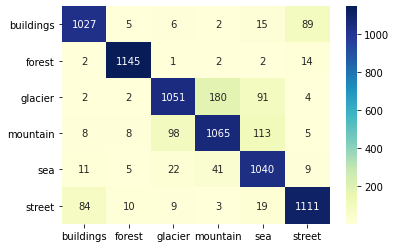

time: 256 ms (started: 2021-01-07 22:41:34 +00:00)


In [50]:
# confusion_mtx_WOA_v3
sns.heatmap(confusion_mtx_WOA_v3, xticklabels=class_names, yticklabels=class_names,
            annot=True, fmt='d', cmap="YlGnBu")

([<matplotlib.axis.XTick at 0x7f00e8b27748>,
 [Text(0, 0, 'buildings'),
  Text(0, 0, 'forest'),
  Text(0, 0, 'glacier'),
  Text(0, 0, 'mountain'),
  Text(0, 0, 'sea'),
  Text(0, 0, 'street')])

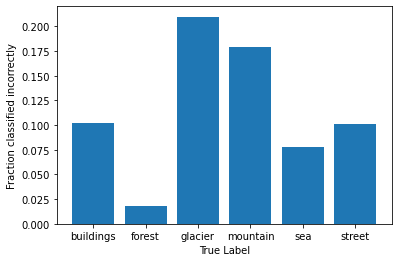

time: 146 ms (started: 2021-01-07 22:41:35 +00:00)


In [51]:
label_frac_error = 1 - np.diag(confusion_mtx_WOA_v3) / np.sum(confusion_mtx_WOA_v3, axis=1)
plt.bar(np.arange(6),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')
plt.xticks([0,1,2,3,4,5],class_names)

# WITH DATA Augmentation

In [52]:
With_Aug_v3 = inception_v3_model.fit(Data_Augmentation,
                        #  callbacks=[LearningRateReducerCb()],
              batch_size= batch_length,
              epochs=epochs_count,
              validation_data=(X_valid, Y_valid))

Epoch 1/10
220/220 [==============================] - 28s 113ms/step - loss: 0.3289 - accuracy: 0.8878 - val_loss: 0.2845 - val_accuracy: 0.9003
Epoch 2/10
220/220 [==============================] - 25s 113ms/step - loss: 0.2468 - accuracy: 0.9140 - val_loss: 0.2955 - val_accuracy: 0.8923
Epoch 3/10
220/220 [==============================] - 25s 112ms/step - loss: 0.2258 - accuracy: 0.9198 - val_loss: 0.2841 - val_accuracy: 0.8927
Epoch 4/10
220/220 [==============================] - 25s 112ms/step - loss: 0.2040 - accuracy: 0.9258 - val_loss: 0.2757 - val_accuracy: 0.8980
Epoch 5/10
220/220 [==============================] - 25s 112ms/step - loss: 0.1858 - accuracy: 0.9321 - val_loss: 0.2712 - val_accuracy: 0.9093
Epoch 6/10
220/220 [==============================] - 24s 111ms/step - loss: 0.1841 - accuracy: 0.9348 - val_loss: 0.2969 - val_accuracy: 0.8973
Epoch 7/10
220/220 [==============================] - 25s 111ms/step - loss: 0.1640 - accuracy: 0.9414 - val_loss: 0.2843 - val_ac

In [53]:
# save the model's trained weights
inception_v3_model.save_weights('/content/drive/MyDrive/Colab Notebooks/Weights/inception_v3_transfer_trained_wts_with-aug2.h5')

time: 2.29 s (started: 2021-01-07 22:45:45 +00:00)


In [54]:
score_WA_v3 = inception_v3_model.evaluate(X_test, Y_test, batch_size=batch_length)
print('Test Loss = ', score_WA_v3[0])
print('Test Accuracy = ', score_WA_v3[1])

115/115 [==============================] - 2s 21ms/step - loss: 0.4846 - accuracy: 0.8758
Test Loss =  0.4845670759677887
Test Accuracy =  0.8757704496383667
time: 2.64 s (started: 2021-01-07 22:45:47 +00:00)


In [55]:
'''CONFUSION MATRIX'''
# Making prediction
y_pred = inception_v3_model.predict(X_test)
y_true = np.argmax(Y_test, axis=-1)

# Plotting the confusion matrix

confusion_mtx_WA_v3 = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

time: 3.73 s (started: 2021-01-07 22:45:50 +00:00)


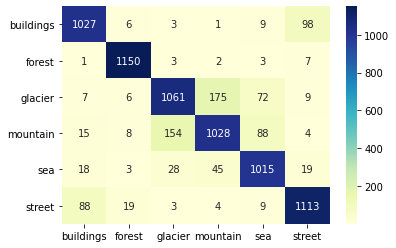

time: 267 ms (started: 2021-01-07 22:45:54 +00:00)


In [56]:
# confusion_mtx_WOA_v3
sns.heatmap(confusion_mtx_WA_v3, xticklabels=class_names, yticklabels=class_names,
            annot=True, fmt='d', cmap="YlGnBu")

([<matplotlib.axis.XTick at 0x7f00e6b798d0>,
 [Text(0, 0, 'buildings'),
  Text(0, 0, 'forest'),
  Text(0, 0, 'glacier'),
  Text(0, 0, 'mountain'),
  Text(0, 0, 'sea'),
  Text(0, 0, 'street')])

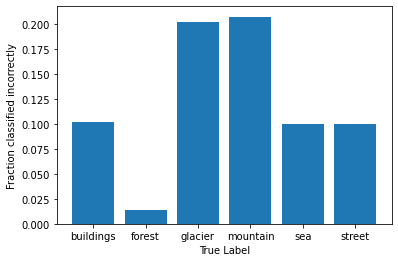

time: 133 ms (started: 2021-01-07 22:45:54 +00:00)


In [57]:
label_frac_error = 1 - np.diag(confusion_mtx_WA_v3) / np.sum(confusion_mtx_WA_v3, axis=1)
plt.bar(np.arange(6),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')
plt.xticks([0,1,2,3,4,5],class_names)

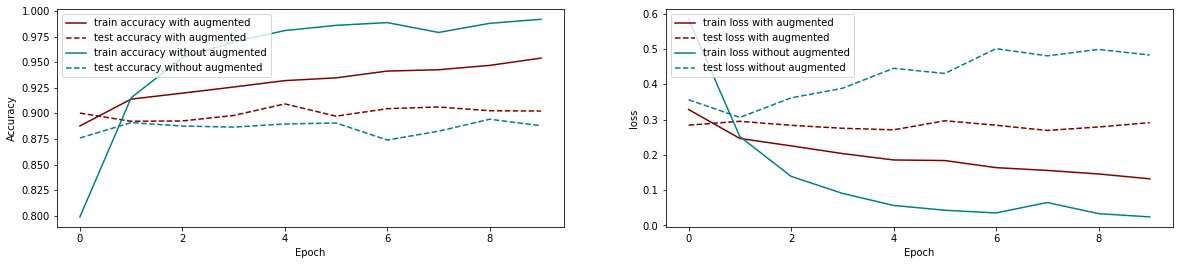

time: 949 ms (started: 2021-01-07 22:45:54 +00:00)


In [58]:
# fig = plt.figure()
# fig.patch.set_facecolor('white')
fig, axis = plt.subplots(1, 2, figsize=(20, 4))
axis[0].plot(With_Aug_v3.history['accuracy'],
         label='train accuracy with augmented',
         c='maroon', ls='-')
axis[0].plot(With_Aug_v3.history['val_accuracy'],
         label='test accuracy with augmented',
         c='maroon',ls='--')

axis[0].plot(With_Out_Aug_v3.history['accuracy'],
         label='train accuracy without augmented',
         c='teal', ls='-')
axis[0].plot(With_Out_Aug_v3.history['val_accuracy'],
         label='test accuracy without augmented',
         c='teal', ls='--')

axis[0].set_xlabel('Epoch')
axis[0].set_ylabel('Accuracy')
axis[0].legend(loc='upper left')


axis[1].plot(With_Aug_v3.history['loss'],
         label='train loss with augmented',
         c='maroon', ls='-')
axis[1].plot(With_Aug_v3.history['val_loss'],
         label='test loss with augmented',
         c='maroon',ls='--')

axis[1].plot(With_Out_Aug_v3.history['loss'],
         label='train loss without augmented',
         c='teal', ls='-')
axis[1].plot(With_Out_Aug_v3.history['val_loss'],
         label='test loss without augmented',
         c='teal', ls='--')

axis[1].set_xlabel('Epoch')
axis[1].set_ylabel('loss')
axis[1].legend(loc='upper left')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/Graphs/inceptionv3_Aug_Validation_error&loss2.png')
plt.show()